In [1]:
from transformers import ViTFeatureExtractor, ViTModel, AutoFeatureExtractor, AutoModel
import torch
import torchvision
from torchvision import transforms
import pickle
from PIL import Image
import os
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import numpy as np
from torch.optim import Adam
from torchvision.utils import make_grid
from tqdm import tqdm
import random

c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def tensor_to_pil_image(tensor):
    # Move tensor to CPU if it's on GPU
    if tensor.is_cuda:
        tensor = tensor.cpu()
    
    # Scale from [-1, 1] to [0, 1]
    tensor = (tensor + 1) / 2
    tensor = tensor.clamp(0, 1)
    
    # Remove channel dimension if it's single channel
    tensor = tensor.squeeze(0)
    
    # Convert tensor to numpy array and scale to [0, 255]
    np_image = tensor.numpy() * 255
    np_image = np_image.astype(np.uint8)  # Convert to uint8
    
    # Convert numpy array to PIL image in 'L' mode (grayscale)
    pil_image = Image.fromarray(np_image, mode='L')
    
    # Convert single-channel image to 3-channel image by repeating the channel
    pil_image = pil_image.convert("RGB")
    
    return pil_image

In [4]:
# Load the feature extractor and ViT models
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model_dino = ViTModel.from_pretrained('facebook/dino-vitb16')
vit_model_siglip = ViTModel.from_pretrained("google/siglip-base-patch16-224")

def extract_global_feature(images, model, strategy='DINO'):
    if isinstance(images, torch.Tensor):
        pil_images = [tensor_to_pil_image(image) for image in images]

    inputs = feature_extractor(images=pil_images, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

        if strategy == 'DINO':
            global_feature = outputs.last_hidden_state[:, 0, :]  # CLS token
        elif strategy == 'SigLIP':
            global_feature = outputs.pooler_output  # MAP block output
        else:
            raise ValueError("Unknown strategy")
    return global_feature

c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using a model of type siglip to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTModel were not initialized from the model checkpoint at google/siglip-base-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encode

In [5]:
class FeatureProjector(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeatureProjector, self).__init__()
        self.output_dim = output_dim
        self.dense = nn.Linear(input_dim, output_dim*output_dim)
    
    def forward(self, x):
        x = self.dense(x)
        return x.view(-1, self.output_dim, self.output_dim).unsqueeze(1)
    
class FiLMLayer(nn.Module):
    def __init__(self, num_features):
        super(FiLMLayer, self).__init__()
        self.gamma = nn.Parameter(torch.ones(1, num_features))
        self.beta = nn.Parameter(torch.zeros(1, num_features))

    def forward(self, x, conditioning):
        gamma = self.gamma * conditioning
        beta = self.beta + conditioning
        return gamma * x + beta
    
# Initialize the projector
# projector = FeatureProjector(input_dim=norm_output.shape[1], output_dim=128)
# projected_features = projector(torch.tensor(norm_output, dtype=torch.float32))

In [6]:
class LinearNoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end, device):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0).to(device)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod).to(device)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1. - self.alpha_cum_prod).to(device)
        
    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)
        
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        return sqrt_alpha_cum_prod  * original  + sqrt_one_minus_alpha_cum_prod * noise
    
    
    def sample_prev_timestep(self, xt, noise_pred, t):
        """
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

# DIFFUSION MODEL

In [18]:
def get_time_embedding(time_steps, t_emb_dim):
    factor = 10000 ** ((torch.arange(
        start=0, end=t_emb_dim//2, device=time_steps.device) / (t_emb_dim // 2)
    ))
    t_emb = time_steps[:, None].repeat(1, t_emb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, down_sample, num_heads):
        super().__init__()
        self.down_sample = down_sample
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        
        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_channels)
        )
        
        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        
        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, kernel_size=4,
                                          stride=2, padding=1) if self.down_sample else nn.Identity()
        
    def forward(self, x, t_emb):
        out = x
        # Resnet Block
        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)
        
        # Attention Block
        # batch_size, channels, h, w = out.shape
        # in_attn = out.reshape(batch_size, channels, h*w)
        # in_attn = self.attention_norm(in_attn)
        # in_attn = in_attn.transpose(1, 2)
        # out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        # out = out + out_attn
        
        out = self.down_sample_conv(out)
        return out
    
class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim,  num_heads):
        super().__init__()
        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ),
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            )
        ])
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            ),
            nn.Sequential(
                nn.SiLU(), 
                nn.Linear(t_emb_dim, out_channels)
            )
        ])
        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ),
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            )
        ])
        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
        ])
    
    def forward(self, x, t_emb):
        out = x 
        #first resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:,:,None,None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        # attention block
        # batch_size, channels, h, w  = out.shape
        # in_attn = out.reshape(batch_size, channels, h*w)
        # in_attn = self.attention_norm(in_attn)
        # in_attn = in_attn.transpose(1, 2)
        # out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        # out = out + out_attn
        
        # second resnet block
        resnet_input = out
        out = self.resnet_conv_first[1](out)
        out = out + self.t_emb_layers[1](t_emb)[:,:,None,None]
        out = self.resnet_conv_second[1](out)
        out = out + self.residual_input_conv[1](resnet_input)
        
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample, num_heads):
        super().__init__()
        self.up_sample = up_sample
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_channels)
        )
        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        
        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=4, 
                                                    stride=2, padding=1) if self.up_sample else nn.Identity()
        
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        # Resnet Block
        out = x
        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)
        
        # Attention Block
        # batch_size, channels, h, w = out.shape
        # in_attn = out.reshape(batch_size, channels, h * w)
        # in_attn = self.attention_norm(in_attn)
        # in_attn = in_attn.transpose(1, 2)
        # out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        # out = out + out_attn
        
        return out

In [19]:
class Unet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.down_channels = [32, 64, 128, 256]
        self.mid_channels = [256, 256, 128]
        self.t_emb_dim = 128
        self.down_sample = [True, True, False]
    
        self.film_layer = FiLMLayer(num_features=1)
        
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(in_channels, self.down_channels[0], kernel_size=3, padding=1)  # Adjusted for concatenation
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_heads=4))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim, num_heads=4))
            
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels) - 1)):
            self.ups.append(UpBlock(self.down_channels[i]*2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_heads=4))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, in_channels, kernel_size=3, padding=1)
        
    def forward(self, x, cond, t):
        projector = FeatureProjector(input_dim=cond.shape[1], output_dim=128).to(device)
        cond_feature = projector(cond)
        cond_feature = cond_feature
        # x = torch.cat([x, cond], dim=1)  # Concatenate input and conditional image
        x = self.film_layer(x, cond_feature)
        out = self.conv_in(x)
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)
        
        for mid in self.mids:
            out = mid(out, t_emb)
            
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
        
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        return out

In [8]:
class ConditionalDataset(Dataset):
    def __init__(self, img_path, img_ext="mpy"):
        self.img_ext = img_ext  # Correct variable name for consistency
        self.image_files = [os.path.join(img_path, f) for f in os.listdir(img_path)]
        self.images = []
        self.inputs = []
        self.conditionals = []
        
        for file in self.image_files:
            filepath = os.path.join(img_path, file)
             # Load image on demand
            with open(filepath, 'rb') as f:
                img_arr = pickle.load(f)  # Assume images are stored as pickled numpy arrays
            
            self.images = img_arr
    
            for idx in range(4, len(self.images)):
                self.inputs.append(self.images[idx])
                self.conditionals.append(self.images[idx - 4])
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        img = self.inputs[index]
        conditional = self.conditionals[index]
        
        # Convert numpy array to tensor
        img_tensor = torchvision.transforms.ToTensor()(img)
        cond_tensor = torchvision.transforms.ToTensor()(conditional)
        
        # Normalize the tensor
        img_tensor = (2 * img_tensor) - 1
        cond_tensor = (2 * cond_tensor) - 1
        return img_tensor, cond_tensor

In [9]:
DATA_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data"

BATCH_SIZE = 64

# create dataset
train_ratio = 0.8
test_ratio = 1 - train_ratio

data = ConditionalDataset(os.path.join(DATA_DIR, "bin_frames"))

train_size = int(train_ratio * (len(data)))
test_size = (len(data)) - train_size

train_data, test_data = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
DATA_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data"
RESULT_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results"
CKPT_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts"

NUM_TIMESTEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02

IN_CHANNELS = 1

TASK_NAME = "vit_ddpm"
NUM_EPOCHS = 40
NUM_SAMPLES = 100
NUM_GRID_ROWS = 10
LR = 0.0001
CKPT_NAME = "vit_ddpm.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_conditional_ddpm():
    # create noise scheduler 
    print("Created Noise Scheduler")
    scheduler = LinearNoiseScheduler(num_timesteps=NUM_TIMESTEPS,
                                     beta_start=BETA_START,
                                     beta_end=BETA_END, 
                                     device=device)
    
    # model
    print("Created Model")
    model = Unet(in_channels=IN_CHANNELS).to(device)
    model.train()
    
    # Create output dirs
    if not os.path.exists(os.path.join(RESULT_DIR, TASK_NAME)):
        os.mkdir(os.path.join(RESULT_DIR, TASK_NAME))
    
    # find checkpoint
    if os.path.exists(os.path.join(CKPT_DIR, CKPT_NAME)):
        print("Loading checkpoint found")
        model.load_state_dict(torch.load(os.path.join(CKPT_DIR, CKPT_NAME), map_location=device))
        
    # Training params
    num_epochs = NUM_EPOCHS
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(num_epochs):
        print(f"starting epoch: {epoch}")
        losses = []
        for img_tensor, cond_tensor in train_loader:
            optimizer.zero_grad()
            print("sampling image...")
            img_tensor = img_tensor.float().to(device)
            cond_tensor = cond_tensor.float().to(device)
            
            cond_features = extract_global_feature(cond_tensor, vit_model_dino)
            cond_features = cond_features.to(device)
            print(type(cond_features), cond_features.shape)
        
            # sample random noise 
            print("Sampling Noise...")
            noise = torch.randn_like(img_tensor).to(device)
            
            # sample timestep
            print("Sampling Timestep...")
            t = torch.randint(0, NUM_TIMESTEPS, (img_tensor.shape[0],)).to(device)
            
            # Add noise to images according to timestep
            print("Adding Noise to Image...")
            noisy_img = scheduler.add_noise(img_tensor, noise, t)
            print("Predicting Noise...")
            noise_pred = model(noisy_img, cond_features, t)
            
            print("Calculating Loss in Predicted Noise...")
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            print("BackProp...")
            loss.backward()
            optimizer.step()
            
        print(f'Finished epoch: {epoch + 1} | Loss: {np.mean(losses)}')
        torch.save(model.state_dict(), os.path.join(CKPT_DIR, CKPT_NAME))
        
    print("Done Training...")

In [102]:
train_conditional_ddpm()

Created Noise Scheduler
Created Model
starting epoch: 0
sampling image...
<class 'torch.Tensor'> torch.Size([64, 768])
Sampling Noise...
Sampling Timestep...
Adding Noise to Image...
Predicting Noise...
cuda:0


c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Calculating Loss in Predicted Noise...
BackProp...
sampling image...


KeyboardInterrupt: 

# TEST WITH MODEL

In [11]:
MODEL_PATH = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/vit_ddpm.pth"

In [20]:
def save_conditional_grid(cond_tensor, nrows=10):
    cond_tensor = (cond_tensor + 1) / 2
    grid = make_grid(cond_tensor, nrow=nrows)
    
    grid_img = torchvision.transforms.ToPILImage()(grid)
    
    grid_img.save(os.path.join(RESULT_DIR, TASK_NAME, "cond_grid_1.png"))
    grid_img.close()
    
def sample_n(dataloader, n):
    all_data = []
    
    for img_tensor, cond_tensor in dataloader:
        all_data.append((img_tensor, cond_tensor))
        
    all_data = [(img, cond) for batch in all_data for img, cond in zip(*batch)]
    
    sampled_data = random.sample(all_data, n)
    
    sampled_inputs = torch.stack([item[0] for item in sampled_data])
    sampled_conds = torch.stack([item[1] for item in sampled_data])
    
    return sampled_inputs.float(), sampled_conds.float()

def sample_conditional(model, scheduler, sampled_conds, grid_rows=None, sample_size=None, save_final=False):
    cond_tensor = sampled_conds.to(device)
    cond_features = extract_global_feature(cond_tensor, vit_model_dino)
    cond_features = cond_features.to(device)
    
    if sample_size is None:
        sample_size = NUM_SAMPLES
        
    if grid_rows is None:
        grid_rows = NUM_GRID_ROWS
    
    xt = torch.randn((sample_size, IN_CHANNELS, 128, 128)).to(device).float()
    
    for i in tqdm(reversed(range(NUM_TIMESTEPS))):
        # xt_cond = torch.cat([xt, cond_tensor], dim=1)
        
        noise_pred = model(xt, cond_features, torch.as_tensor(i).unsqueeze(0).to(device))
        
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
        
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=grid_rows)
        img = torchvision.transforms.ToPILImage()(grid)
        
        if save_final and i==0:
            if not os.path.exists(os.path.join(RESULT_DIR, TASK_NAME, "samples")):
                os.mkdir(os.path.join(RESULT_DIR, TASK_NAME, "samples"))
            img.save(os.path.join(RESULT_DIR, TASK_NAME, "samples", "x0_{}.png".format(i)))
            img.close()
            return ims
            
        elif not save_final:
            if not os.path.exists(os.path.join(RESULT_DIR, TASK_NAME, "samples")):
                os.mkdir(os.path.join(RESULT_DIR, TASK_NAME, "samples"))
            img.save(os.path.join(RESULT_DIR, TASK_NAME, "samples", "x0_{}.png".format(i)))
            img.close()
        
def infer_conditional():
    model = Unet(in_channels=IN_CHANNELS).to(device)
    model.load_state_dict(torch.load(MODEL_PATH))
    
    model.eval()
    
    scheduler = LinearNoiseScheduler(num_timesteps=NUM_TIMESTEPS,
                                     beta_start=BETA_START,
                                     beta_end=BETA_END,
                                     device=device)
    
    _, conditional_imgs = sample_n(test_loader, NUM_SAMPLES)
    save_conditional_grid(conditional_imgs)
    
    with torch.no_grad():
        sample_conditional(model, scheduler, conditional_imgs)    

In [21]:
infer_conditional()

1000it [15:09,  1.10it/s]


### EXPLORE ViT FEATURES

torch.Size([64, 3, 224, 224]) <class 'torch.Tensor'>
(768,) (768,)


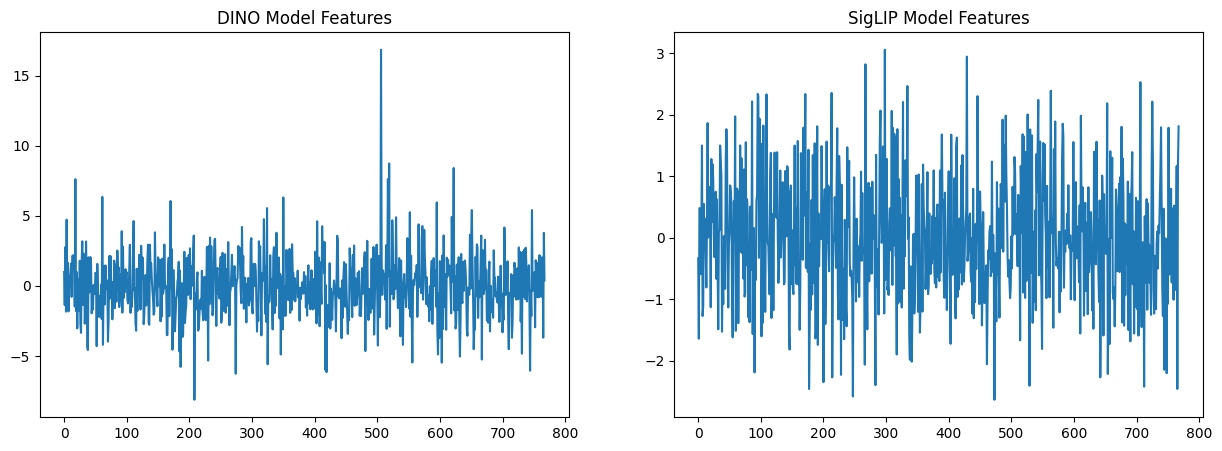

In [35]:
from matplotlib import pyplot as plt 

for idx, (img, cond) in enumerate(train_loader):
    image_batch_resized = torch.nn.functional.interpolate(cond, size=(224, 224))
    image_batch_resized = image_batch_resized.repeat(1, 3, 1, 1)
    
    print(image_batch_resized.shape, type(image_batch_resized))

    inputs = feature_extractor(images=[Image.fromarray(img.numpy().astype('uint8').transpose(1, 2, 0)) for img in image_batch_resized], return_tensors="pt")

    # Extract features using DINO model
    with torch.no_grad():
        outputs_dino = vit_model_dino(**inputs)
        features_dino = outputs_dino.last_hidden_state
    
    with torch.no_grad():
        outputs_siglip = vit_model_siglip(**inputs)
        features_siglip = outputs_siglip.last_hidden_state
        
    features_dino_np = features_dino[0, 0, :].numpy()
    features_siglip_np = features_siglip[0, 0, :].numpy()
    
    print(features_dino_np.shape, features_siglip_np.shape)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(features_dino_np)
    axes[0].set_title("DINO Model Features")
    axes[1].plot(features_siglip_np)
    axes[1].set_title("SigLIP Model Features")
    
    plt.show()

    break